In [78]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

%config InlineBackend.figure_format = 'retina'

1. Stock prices are changing not by arbitrarty real value but by multiples of minimum possible price change called tick size, which is usually equals to $0.01, though it might be different for certain stocks and exchanges.
2. From the host answer we know that prices were normalized by dividing them by the price (WAP to be precise) at seconds_in_bucket=0 for each stock_id/time_id. So tick size will also be divided by this price.

Then if we find normalized tick size by taking minimum of all price changes for each stock_id/time_id, and assuming real tick size=$0.01, we can restore original price as:

$$ S_0 = 0.01/{normalized tick size}$$

In [80]:
DATA_DIR = DATA_DIR = 'C:/Users/gybj0/Desktop/data'
df_files = pd.DataFrame(
    {'book_path': glob.glob(f'{DATA_DIR}/optiver_volatility/book_train.parquet/**/*.parquet')}) \
    .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')
df_target = pd.read_csv(f'{DATA_DIR}/optiver_volatility/train.csv')
df_target = df_target.groupby('time_id').target.mean()

In [81]:
df_target_train = pd.read_csv(f'{DATA_DIR}/optiver_volatility/train.csv')

In [82]:
def calc_price(df):
    diff = abs(df.diff())
    min_diff = np.nanmin(diff.where(lambda x: x > 0))
    n_ticks = (diff / min_diff).round()
    return 0.01 / np.nanmean(diff / n_ticks)

def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df

In [83]:
%%time
df_prices = pd.concat(Parallel(n_jobs=-1, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

In [84]:
df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
df_prices.head()

stock_id,0,1,2,3,4,5,6,7,8,9,...,115,116,118,119,120,122,123,124,125,126
time_id,,,,,,,,,,,,,,,,,,,,,
5,193.382499,152.416327,123.461428,226.012250,619.198910,738.256609,370.275801,245.871005,283.881404,238.394801,...,88.143530,246.326035,210.790509,66.225357,96.217049,142.352639,108.310134,84.344766,53.375172,310.446018
11,199.230489,149.512019,128.641219,249.893186,614.775587,769.481105,411.690134,256.711248,278.116771,244.391095,...,90.285607,275.920002,213.987639,63.064600,101.239474,136.924692,105.482065,91.095212,55.886795,300.948142
16,208.900108,104.885672,118.687626,164.755260,534.006468,584.016623,236.595114,208.127709,123.656631,177.405905,...,70.035150,189.724268,281.007926,53.520546,74.554427,93.370637,77.421019,55.054433,53.084003,194.495613
31,216.138269,137.831221,138.326832,235.951400,657.636985,804.561599,358.949333,260.607163,194.206656,232.626610,...,90.688217,256.869817,235.129520,61.245171,90.928457,134.847296,103.739264,92.465021,58.124482,259.149086
62,214.516318,140.650237,137.213402,238.242521,639.647230,765.430308,403.068356,250.621847,187.756581,243.460002,...,89.140911,248.061738,231.193793,59.542960,87.940275,125.482870,103.529649,96.060419,57.373160,259.214214


In [85]:
df_prices_norm = df_prices.fillna(df_prices.mean())
df_prices_norm = pd.DataFrame(minmax_scale(df_prices_norm), index=df_prices_norm.index)

# t-SNE

In [23]:
%%time
emb = TSNE(n_components=2, perplexity=40, learning_rate=50, verbose=1, init='pca', n_iter=2000,
           early_exaggeration=12).fit_transform(df_prices_norm)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3830 samples in 0.007s...
[t-SNE] Computed neighbors for 3830 samples in 0.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3830
[t-SNE] Computed conditional probabilities for sample 2000 / 3830
[t-SNE] Computed conditional probabilities for sample 3000 / 3830
[t-SNE] Computed conditional probabilities for sample 3830 / 3830
[t-SNE] Mean sigma: 0.232494


c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.311077
[t-SNE] KL divergence after 2000 iterations: 0.155879
CPU times: total: 9min 35s
Wall time: 1min 10s


Text(0.5, 1.0, 'TSNE time_id embeddings')

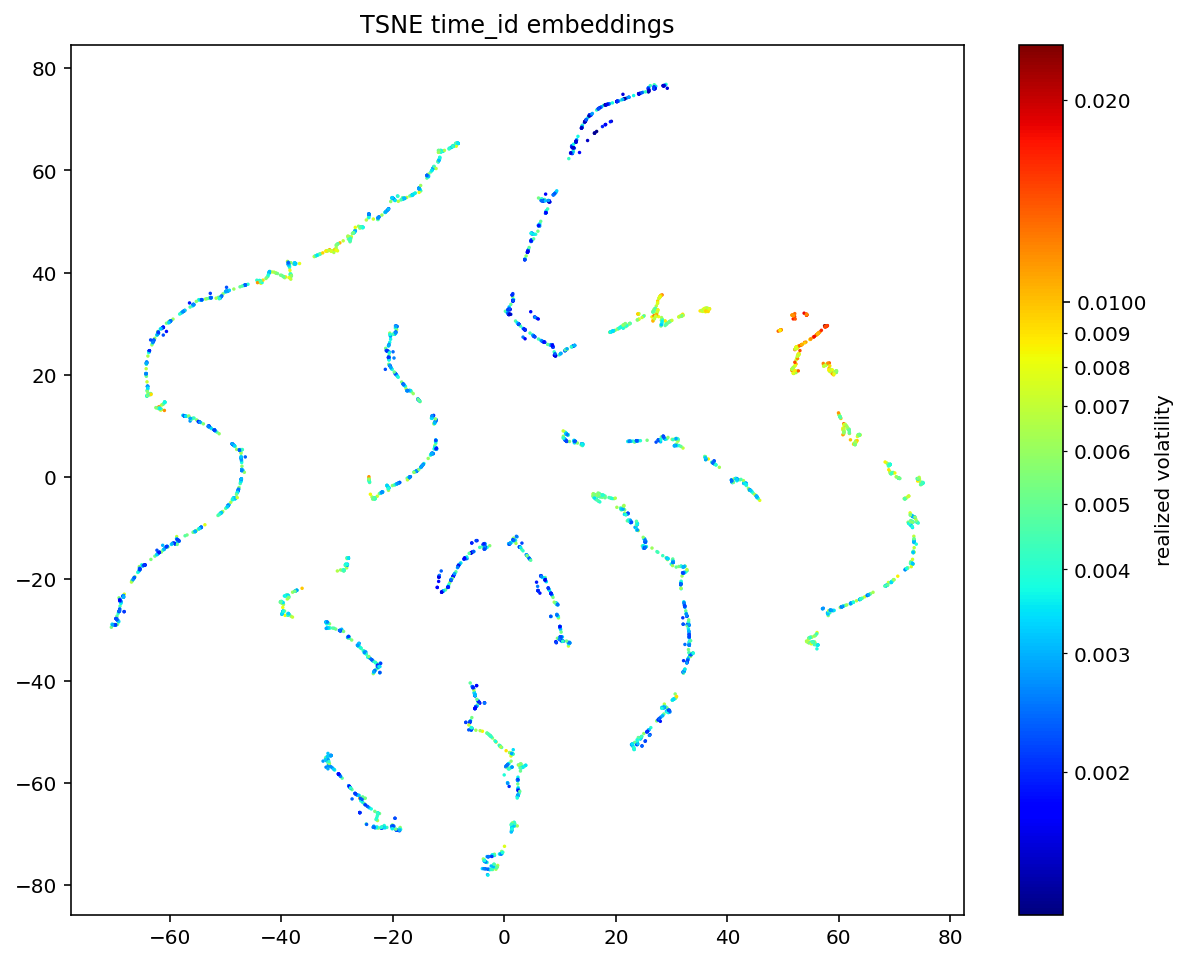

In [24]:
plt.figure(figsize=(10, 8))
plt.scatter(emb[:, 0], emb[:, 1], s=3, c=df_target, edgecolors='none', cmap='jet', norm=mpl.colors.LogNorm())
cb = plt.colorbar(label='realized volatility', format=mpl.ticker.ScalarFormatter(),
                  ticks=mpl.ticker.LogLocator(10))
cb.ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.title('TSNE time_id embeddings')

In [26]:
%%time
emb = SpectralEmbedding(random_state = 42).fit_transform(df_prices_norm)

CPU times: total: 7.08 s
Wall time: 2.66 s


Text(0.5, 1.0, 'Spectral embeddings time_id embeddings')

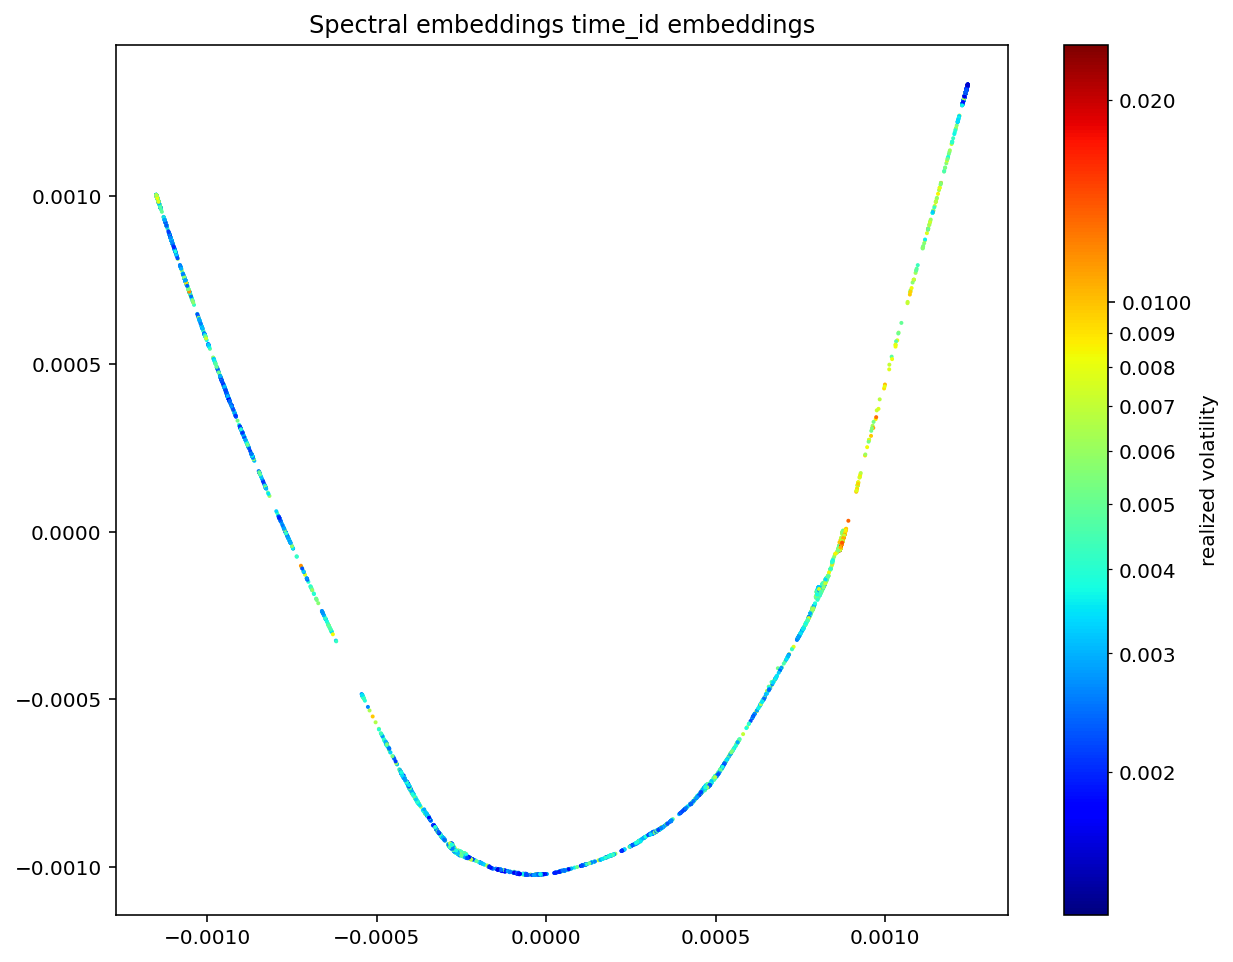

In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(emb[:, 0], emb[:, 1], s=4, c=df_target, edgecolors='none', cmap='jet', norm=mpl.colors.LogNorm())
cb = plt.colorbar(label='realized volatility', format=mpl.ticker.ScalarFormatter(),
                  ticks=mpl.ticker.LogLocator(10))
cb.ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.title('Spectral embeddings time_id embeddings')

# Use simple linear regression to improve

In [86]:
def calc_rv(r):
    df = pd.read_parquet(r.book_path)
    df['wap'] = (df.ask_price1 * df.bid_size1 + df.bid_price1 * df.ask_size1) / (df.ask_size1 + df.bid_size1)
    df = df.groupby('time_id').wap.apply(lambda x: (np.log(x).diff() ** 2).sum() ** 0.5).reset_index()
    df.rename(columns={'wap': 'rv'}, inplace=True)
    df['stock_id'] = r.stock_id
    return df
    
df_rv_train = pd.concat(Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_rv)(r) for _, r in df_files.iterrows()))

In [87]:
df_rv_train.head()

,time_id,rv,stock_id
0,5,0.004499,0
1,11,0.001204,0
2,16,0.002369,0
3,31,0.002574,0
4,62,0.001894,0


In [88]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score

In [89]:
%%time
nn = NearestNeighbors()
nn.fit(df_prices_norm)
nn_ind = nn.kneighbors(df_prices_norm, n_neighbors = 10, return_distance = False)

CPU times: total: 1.09 s
Wall time: 145 ms


In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

result = []
for nn_count in range(1, 11):
    time_ind = df_target_train.time_id.factorize()[0]
    stock_ind = df_target_train.stock_id.factorize()[0]
    train = df_rv_train.pivot('time_id','stock_id','rv')
    
    train = pd.DataFrame(train.values[nn_ind[time_ind, :nn_count], stock_ind[:, None]], index = df_target_train.index)
    train.rename(lambda x: f'rv_{x}', axis = 1, inplace = True)
    train.fillna(train.mean(), inplace = True)

    model = LinearRegression()
    scores = cross_val_score(model, train, df_target_train.target,
                            groups = df_target_train.time_id,
                            scoring = make_scorer(rmspe),
                            fit_params = {'sample_weight': 1 / df_target_train.target ** 2})

    result.append({'nn_count': nn_count, 'score': scores.mean()})

In [107]:
df_rv_train.pivot('time_id','stock_id','rv').values[nn_ind[time_ind, :nn_count]]

array([[[0.00449936, 0.00624493, 0.00178692, ..., 0.0039259 ,
         0.00187287, 0.00725513],
        [0.00521071, 0.00714774, 0.0018043 , ..., 0.00424552,
         0.00209285, 0.00943255],
        [0.00255772, 0.00446619, 0.00178734, ..., 0.00324698,
         0.00169777, 0.00628115],
        ...,
        [0.00600815, 0.01026253, 0.00299416, ..., 0.0053541 ,
         0.00297927, 0.01091209],
        [0.00328807, 0.00615361, 0.00193972, ..., 0.00368788,
         0.00180867, 0.00599868],
        [0.00516087, 0.00599912, 0.0021089 , ..., 0.00408884,
         0.00197138, 0.00808671]],

       [[0.00120443, 0.00230525, 0.0007497 , ..., 0.00195902,
         0.00085803, 0.00329429],
        [0.00095787, 0.00261376, 0.00107481, ..., 0.00170537,
         0.0009201 , 0.00361849],
        [0.00176845, 0.00220976, 0.00073467, ..., 0.0020982 ,
         0.00072585, 0.00319996],
        ...,
        [0.00324092, 0.00317597, 0.00131963, ..., 0.00274607,
         0.00146459, 0.00545983],
        [0.0

In [111]:
df_prices_norm

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
time_id,,,,,,,,,,,,,,,,,,,,,
5,0.618272,0.870655,0.552631,0.735930,0.804299,0.812166,0.585260,0.724101,0.753313,0.838174,...,0.847039,0.725234,0.099813,0.650358,0.848136,0.928711,0.934403,0.757303,0.636126,0.863727
11,0.701341,0.844599,0.654116,0.848059,0.789978,0.880214,0.665091,0.804527,0.731652,0.880552,...,0.896366,0.878752,0.130230,0.584336,0.942446,0.871643,0.885871,0.869485,0.772331,0.822066
16,0.838694,0.444232,0.459101,0.448309,0.528474,0.476028,0.327572,0.444076,0.151266,0.407136,...,0.430045,0.431614,0.767861,0.384980,0.441361,0.413728,0.404318,0.270542,0.620335,0.355131
31,0.941510,0.739804,0.843880,0.782597,0.928749,0.956666,0.563426,0.833431,0.416359,0.797407,...,0.905637,0.779930,0.331374,0.546332,0.748828,0.849802,0.855963,0.892249,0.893681,0.638722
62,0.918470,0.765095,0.822065,0.793355,0.870504,0.871386,0.648472,0.759348,0.392123,0.873972,...,0.870006,0.734238,0.293929,0.510776,0.692717,0.751347,0.852366,0.951999,0.852937,0.639007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32751,0.601585,0.838798,0.722089,0.819084,0.910765,0.827600,0.622707,0.769725,0.633947,0.779174,...,0.855799,0.842966,0.396621,0.521362,0.795802,0.858040,0.852394,0.920830,0.822635,0.845346
32753,0.708706,0.791225,0.657814,0.825176,0.796653,0.849805,0.621423,0.753926,0.657803,0.859878,...,0.917101,0.845230,0.120223,0.563480,0.783865,0.867527,0.861381,0.815958,0.778233,0.774642
32758,0.690557,0.507870,0.929246,0.692796,0.714553,0.792937,0.854553,0.637326,0.184835,0.609836,...,0.666659,0.617201,0.110116,0.185187,0.554549,0.601448,0.617207,0.702783,0.810879,0.390550


In [112]:
df_target_train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


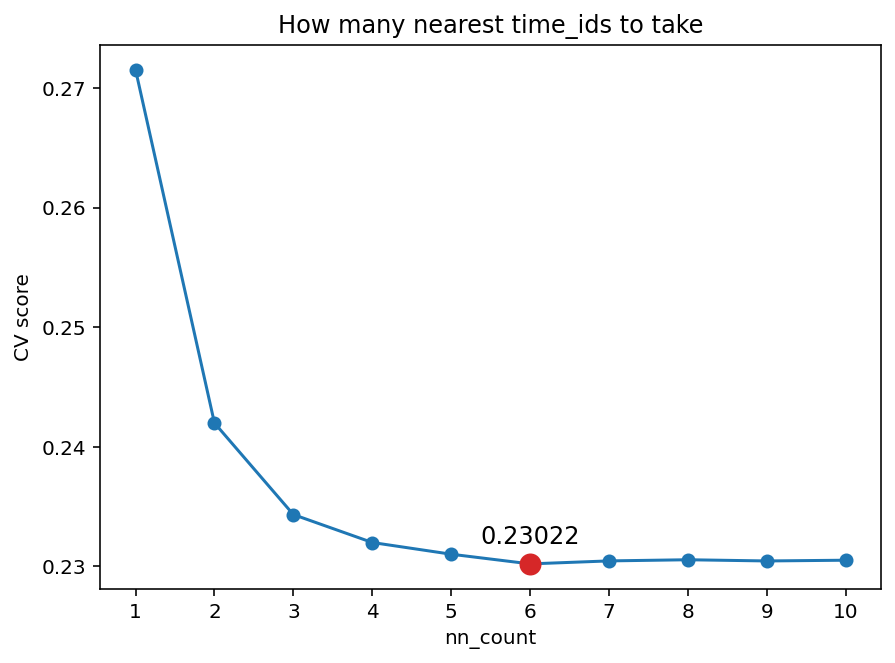

In [49]:
df_results = pd.DataFrame(result)
ax = df_results.plot(x='nn_count', y='score', style='-C0o', figsize=(7, 5), legend=False)
best = df_results.iloc[df_results.score.argmin()]
plt.plot(best.nn_count, best.score, 'C3o', markersize=10)
plt.annotate(f'{best.score:.5f}', xy=(best.nn_count, best.score), xytext=(0, 10), 
             fontsize=12, textcoords='offset points', ha='center')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
plt.ylabel('CV score')
plt.title('How many nearest time_ids to take');

Text(0.5, 1.0, 'Feature weights')

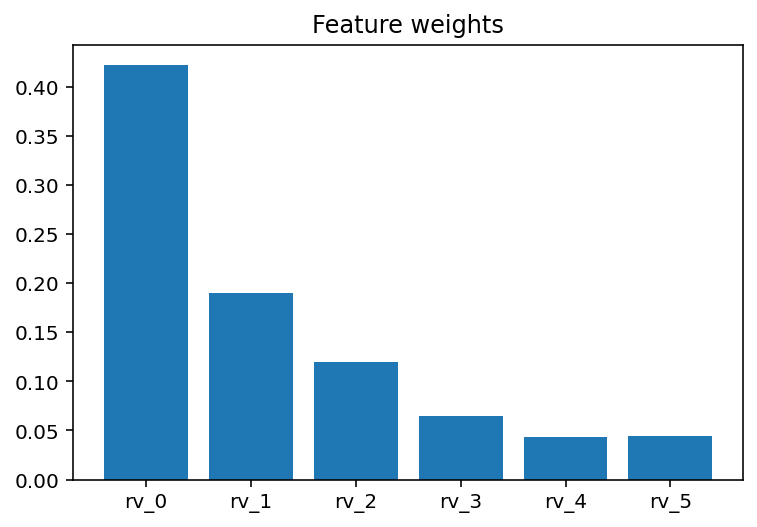

In [50]:
nn_count = 6

time_ind = df_target_train.time_id.factorize()[0]
stock_ind = df_target_train.stock_id.factorize()[0]
df_train = df_rv_train.pivot('time_id', 'stock_id', 'rv')

df_train = pd.DataFrame(df_train.values[
        nn_ind[time_ind, :nn_count],
        stock_ind[:, None]], 
    index=df_target_train.index)
df_train.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
df_train.fillna(df_train.mean(), inplace=True)

model = LinearRegression()
model.fit(df_train, df_target_train.target, sample_weight=1 / df_target_train.target ** 2)

plt.bar(x=df_train.columns, height=model.coef_)
plt.title('Feature weights')

In [ ]:
model.predict()

In [53]:
df_train

,rv_0,rv_1,rv_2,rv_3,rv_4,rv_5
0,0.004499,0.005211,0.002558,0.003977,0.004643,0.003591
1,0.001204,0.000958,0.001768,0.001990,0.001852,0.001806
2,0.002369,0.002972,0.002153,0.002573,0.002892,0.002353
3,0.002574,0.001694,0.002973,0.002799,0.001950,0.001403
4,0.001894,0.002106,0.002884,0.002534,0.001918,0.002741
...,...,...,...,...,...,...
428927,0.003691,0.004399,0.006956,0.005660,0.007419,0.006716
428928,0.004104,0.003630,0.004640,0.003515,0.003370,0.003861
428929,0.003118,0.002177,0.002716,0.002983,0.004288,0.002680
428930,0.003661,0.003971,0.003070,0.003188,0.003047,0.005786


In [58]:
df_files = pd.DataFrame({'book_path': glob.glob(f'{DATA_DIR}/optiver_volatility/book_test.parquet/**/*.parquet')}) \
    .assign(stock_id=lambda x: x.book_path.str.extract("stock_id=(\d+)").astype('int')) \
    .sort_values('stock_id')

df_submission = pd.read_csv(f'{DATA_DIR}/optiver_volatility/test.csv')

In [ ]:
df_prices_denorm_test = pd.concat(Parallel(n_jobs=-1, verbose=0)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
df_prices_denorm_test = df_prices_denorm_test.pivot('time_id', 'stock_id', 'price')
df_prices_denorm_scaled_test = df_prices_denorm_test.fillna(df_prices_denorm_test.mean())
df_prices_denorm_scaled_test = pd.DataFrame(minmax_scale(df_prices_denorm_scaled_test), index=df_prices_denorm_test.index)

df_rv_test = pd.concat(Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_rv)(r) for _, r in df_files.iterrows()))

if len(df_prices_denorm_scaled_test) == 1:
    nn_ind = np.zeros((3, nn_count), dtype='int')
else:
    nn = NearestNeighbors(algorithm='brute')
    nn.fit(df_prices_denorm_scaled_test)
    nn_ind = nn.kneighbors(df_prices_denorm_scaled_test, n_neighbors=10, return_distance=False)

time_ind = df_submission.time_id.factorize()[0]
stock_ind = df_submission.stock_id.factorize()[0]
df_test = df_rv_test.pivot('time_id', 'stock_id', 'rv')

df_test = pd.DataFrame(df_test.values[
        nn_ind[time_ind, :nn_count],
        stock_ind[:, None]], 
    index=df_submission.index)
df_test.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [68]:
df_test

,rv_0,rv_1,rv_2,rv_3,rv_4,rv_5
0,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294
1,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294
2,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294


In [67]:
model.predict(df_test)

array([0.00030564, 0.00030564, 0.00030564])